# **IRLS $L_{1}$ - $L_{1}$**

This notebook solves the following inverse problem using the Iterative Least Squares (IRLS) algorithm and it is ilustrated with a 'spiky' deconvolution example.


$$
\min _{m}\left\|Gm-d\right\|_{1} + \beta\left\|m\right\|_{1}
$$




$$
=\min _{m}\left\|\left[\begin{array}{c}
G \\
\beta I
\end{array}\right] m-\left[\begin{array}{l}
d \\
0
\end{array}\right]\right\|_{1}
$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import pylops
import scipy
import scipy.io
import time
import numpy as np
import matplotlib.pyplot as plt
from pylops.basicoperators import *
from pylops.optimization import *
from pylops.utils.backend import get_array_module, get_module_name, to_numpy
from pylops.utils.wavelets import ricker
from pylops.optimization.leastsquares import normal_equations_inversion, \
    regularized_inversion
from pylops.optimization.sparsity import irls

random.seed(1)
np.random.seed(1)

In [2]:
def spiky_deconvolution():
    dt = 1e-2
    T = 5
    t = np.linspace(0, T, int(T/dt))
    n = len(t)

    m = 10
    r = np.zeros(n)
    r[random.sample(range(0, n-1), m)] = -1 + 2*np.random.rand(m)

    h, th, hcenter = ricker(t[:101], f0=3)

    Cop = pylops.signalprocessing.Convolve1D(n, h=h, offset=hcenter, dtype='float32' ) 
    
    return Cop, r, Cop * r

In [3]:
def spnoise(signal, per=0.5, scale=1):
    """
    Salt and pepper noise for a 1D signal
    
    signal : 1D signal to add noise
    per    : Percentage of noise
    scale  : Scalar related to the amplitude of the noise
             when = 1, noise have the amplitude of signal.max()
             and signal.min()
    """
    n = signal.shape[0]
    noiseperc = per
    isalt = np.random.permutation(np.arange(n))[:int(noiseperc*n)]
    ipepper = np.random.permutation(np.arange(n))[:int(noiseperc*n)]

    nsignal = signal.copy()
    nsignal[isalt] = signal.max()*scale
    nsignal[ipepper] = signal.min()*scale
    
    return nsignal

## Create data

In [4]:
A, x, b = spiky_deconvolution()
dt = 1e-2
T = 5
t = np.linspace(0, T, int(T/dt))
n = len(t)

## No noise

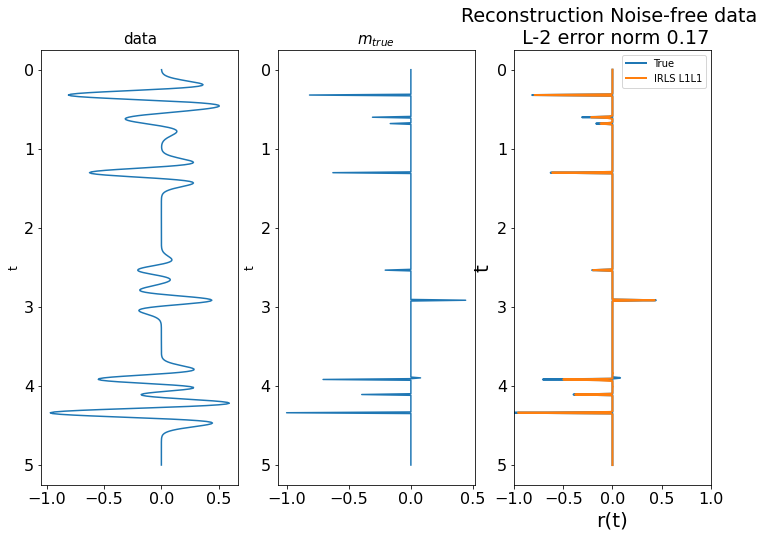

In [5]:
epsI = 4.
x2 = irls(A, b, threshR=True, kind="datamodel", # x0=x0, 
          nouter=101, epsR=1e-3, epsI=np.sqrt(epsI), warm=True, **dict(iter_lim=100))[0]

fig, axs = plt.subplots(1,3, figsize=(12,8))
axs[0].plot(b,t, label='data')
axs[0].set_title('data', fontsize=15)
axs[0].set_ylabel('t', fontsize=12)
axs[0].invert_yaxis()
axs[1].plot(x,t, label='mtrue')
axs[1].set_title('$m_{true}$', fontsize=15)
axs[1].invert_yaxis()
axs[1].set_ylabel('t', fontsize=12)
axs[2].plot(x,t,linewidth=2,label='True')
axs[2].plot(x2,t,linewidth=2,label='IRLS L1L1')
axs[2].set_xlabel('r(t)',fontsize=20)
axs[2].set_ylabel('t',fontsize=20)
axs[2].legend(fontsize=10)
axs[2].set_xlim((-1, 1))
axs[2].invert_yaxis()
axs[2].set_title('Reconstruction Noise-free data \n L-2 error norm %.2f' 
                 % (np.linalg.norm(x2 - x)/np.linalg.norm(x)));

## *'Salt and pepper'* noise

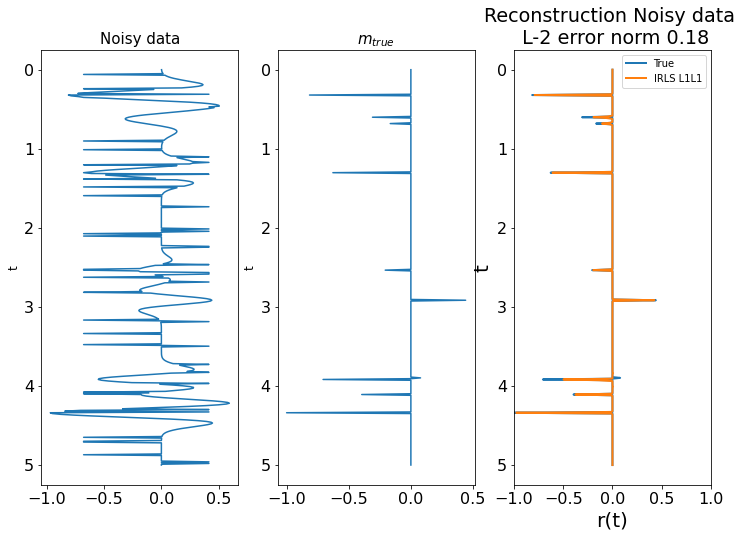

In [6]:
# Add salt and pepper noise
bn = spnoise(signal=b, per=0.05, scale=0.7)

epsI = 4.
x3 = irls(A, bn, threshR=True, kind="datamodel",
          nouter=101, epsR=1e-3, epsI=np.sqrt(epsI), warm=True, 
          **dict(iter_lim=500))[0]

fig, axs = plt.subplots(1,3, figsize=(12,8))
axs[0].plot(bn,t, label='Noisy data')
axs[0].set_title('Noisy data', fontsize=15)
axs[0].set_ylabel('t', fontsize=12)
axs[0].invert_yaxis()
axs[1].plot(x,t, label='mtrue')
axs[1].set_title('$m_{true}$', fontsize=15)
axs[1].invert_yaxis()
axs[1].set_ylabel('t', fontsize=12)
axs[2].plot(x,t,linewidth=2,label='True')
axs[2].plot(x3,t,linewidth=2,label='IRLS L1L1')
axs[2].set_xlabel('r(t)',fontsize=20)
axs[2].set_ylabel('t',fontsize=20)
axs[2].legend(fontsize=10)
axs[2].set_xlim((-1, 1))
axs[2].invert_yaxis()
axs[2].set_title('Reconstruction Noisy data \n L-2 error norm %.2f' 
                 % (np.linalg.norm(x3 - x)/np.linalg.norm(x)));

## Laplace noise

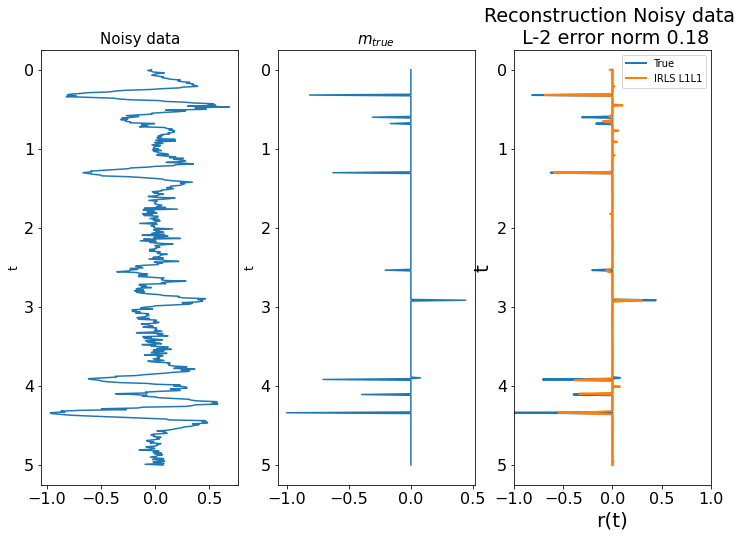

In [7]:
bln = b + np.random.laplace(loc=0.0, scale=.05, size=b.shape)

epsI = 1.
x4 = irls(A, bln, threshR=True, kind="datamodel",
          nouter=101, epsR=10e-4, epsI=np.sqrt(epsI), warm=True, 
          **dict(iter_lim=100))[0]

fig, axs = plt.subplots(1,3, figsize=(12,8))
axs[0].plot(bln,t, label='Noisy data')
axs[0].set_title('Noisy data', fontsize=15)
axs[0].set_ylabel('t', fontsize=12)
axs[0].invert_yaxis()
axs[1].plot(x,t, label='mtrue')
axs[1].set_title('$m_{true}$', fontsize=15)
axs[1].invert_yaxis()
axs[1].set_ylabel('t', fontsize=12)
axs[2].plot(x,t,linewidth=2,label='True')
axs[2].plot(x4,t,linewidth=2,label='IRLS L1L1')
axs[2].set_xlabel('r(t)',fontsize=20)
axs[2].set_ylabel('t',fontsize=20)
axs[2].legend(fontsize=10)
axs[2].set_xlim((-1, 1))
axs[2].invert_yaxis()
axs[2].set_title('Reconstruction Noisy data \n L-2 error norm %.2f' 
                 % (np.linalg.norm(x3 - x)/np.linalg.norm(x)));

## Gaussian noise

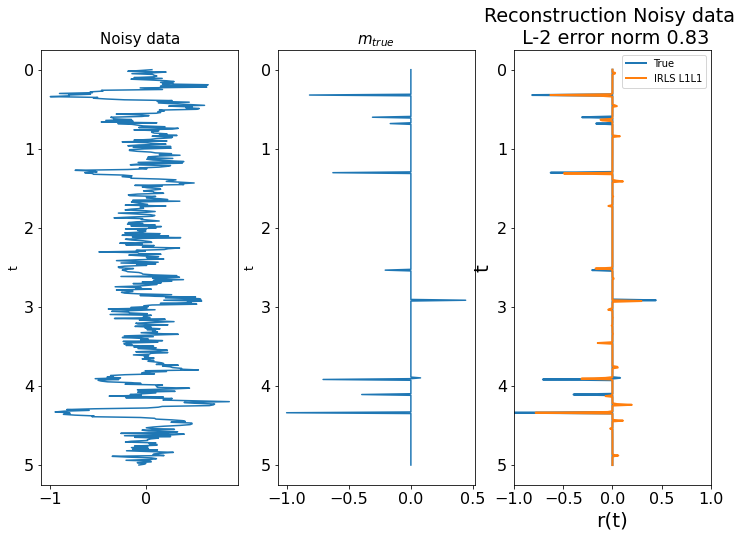

In [8]:
bng = np.zeros(b.shape)
for i in range(0, bng.shape[0]):
    bng[i] = b[i] + np.random.normal(0, np.sqrt(0.025), 1)

epsI = 4.
x4 = irls(A, bng, threshR=True, kind="datamodel",
          nouter=101, epsR=10e-4, epsI=np.sqrt(epsI), warm=True, 
          **dict(iter_lim=100))[0]

fig, axs = plt.subplots(1,3, figsize=(12,8))
axs[0].plot(bng,t, label='Noisy data')
axs[0].set_title('Noisy data', fontsize=15)
axs[0].set_ylabel('t', fontsize=12)
axs[0].invert_yaxis()
axs[1].plot(x,t, label='mtrue')
axs[1].set_title('$m_{true}$', fontsize=15)
axs[1].invert_yaxis()
axs[1].set_ylabel('t', fontsize=12)
axs[2].plot(x,t,linewidth=2,label='True')
axs[2].plot(x4,t,linewidth=2,label='IRLS L1L1')
axs[2].set_xlabel('r(t)',fontsize=20)
axs[2].set_ylabel('t',fontsize=20)
axs[2].legend(fontsize=10)
axs[2].set_xlim((-1, 1))
axs[2].invert_yaxis()
axs[2].set_title('Reconstruction Noisy data \n L-2 error norm %.2f' 
                 % (np.linalg.norm(x4 - x)/np.linalg.norm(x)));